# Villarica Snow Monitoring with Google Earth Engine

Villarrica volcano is It is 2,847 meters (9,377 ft) tall active volcano located in the southern Andes of Chile. The upper part of Villarrica volcano is permanently covered in snow and has some 40 km2 of glaciers. However, the amount of snow and ice on the volcano has been decreasing in recent years due to climate change. It is important to note that the snow cover on Villarrica volcano can vary depending on the time of year and the weather conditions. During the summer months, the snow cover may melt completely, while during the winter months, it may be much thicker. This will be shown in this notebook using Google Earth Engine (GEE) to aquire the images and some basic processing to determine snow coverage and how it varies during the year.

In [1]:
#Import necessary libraries
import pandas as pd
import ee
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt
import datetime

In [2]:
# GEE authentication
ee.Authenticate()

Enter verification code: 4/1Adeu5BU9g3QBh7LP8lTVlFbR6D_-FFIL84JXukwjUDgJpexT5Oj-PEaOWbE

Successfully saved authorization token.


In [3]:
ee.Initialize()

## Image Processing Workflow

We will now load just one image, do some processing and explain the workflow that will be latter on applied to an image collection to monitor snow coverage in a simple way.

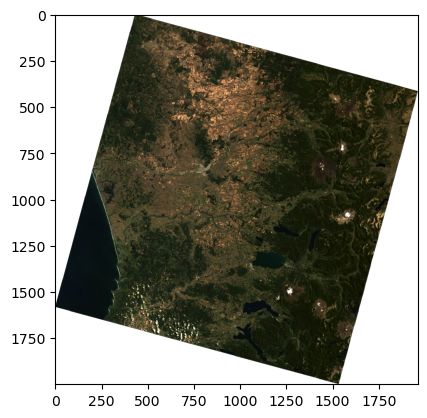

In [4]:
# Villarrica volcano coordinates: -39.418781160639405, -71.9352118133248 this si our point of interest (poi)

#lat = -39.418781160639405 
#lon = -71.9352118133248

#poi = ee.Geometry.Point(lon,lat)

# parameters to set image size, select color bands, etc.

parameters = {
    
'min':7000, 
'max':16000, 
'dimensions':2000, 
'bands':['SR_B4','SR_B3','SR_B2']

}

# get the image

url = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_233087_20220131').getThumbUrl(parameters)

response = requests.get(url)

img = Image.open(BytesIO(response.content))

#plot the image
plt.imshow(img)

The above is the entire satellite image that includes our point of interest (the volcano is one if the white spots in the image). We will zoom into the Villarica and determine how many white pixels are there in the image. By dividing the amount of white pixels by the total amount of pixels we can get an idea of the snow coverage in th area.

In [5]:
# Villarrica volcano coordinates: -39.418781160639405, -71.9352118133248 this si our point of interest (poi)

lat = -39.418781160639405 
lon = -71.9352118133248

poi = ee.Geometry.Point(lon,lat)

roi = poi.buffer(7000) # 7km around the poi

# parameters to crop image, set image size, select color bands, etc.

parameters = {
    
'min':7000, 
'max':16000, 
'dimensions':300, 
'bands':['SR_B4','SR_B3','SR_B2'],
'region': roi

}

# get the image

url = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_233087_20220131').getThumbUrl(parameters)

response = requests.get(url)

img0 = Image.open(BytesIO(response.content))

*'img0'*  is basically a zoom in for our volcano from the previous image. We will now select just one band from the above image to create kind of the same image but in a greyscale

In [6]:
# function to select only band 3 from image
def single_band_g(img):
    img_t = np.array(img)[:,:,2]
    return img_t

img1 = single_band_g(img0) # grayscale image

Every pixel of *'img1'* has a value between 0 and 255. Total white is 255 and 0 is total black. For the analysis we will state that every pixel with a value grater than 200 is a white pixel, hence a 30x30 meter snow covered square in the terrain. And every pixel with a value equal or lower than 200 is not covered. 
Below we define a fucntion for doing so.

In [9]:
def binary_img(img):
    array = np.array(img)
    array[array > 200] = 255
    array[array <= 200] = 0
    img_t = array
    return img_t

img2 = binary_img(img1)

Below we will plot the 3 images side by side to have a visual idea and understand better what we aim to calculate

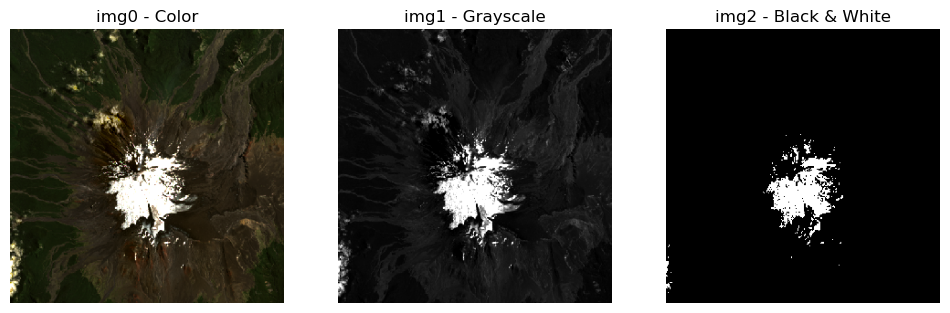

In [11]:
f, axarr = plt.subplots(1,3, figsize = (12,5))

# img0 --> color image
axarr[0].imshow(img0)
axarr[0].axis('off')
axarr[0].title.set_text('img0 - Color')

# img1 --> grayscale image
axarr[1].imshow(img1, cmap='gray')
axarr[1].axis('off')
axarr[1].title.set_text('img1 - Grayscale')

# img2 --> black or white image
axarr[2].imshow(img2, cmap='gray')
axarr[2].axis('off')
axarr[2].title.set_text('img2 - Black & White')


np.set_printoptions(suppress=True)

We can get the snow coverage by calculating the proportion of white pixels in the last image.

In [12]:
def snow_coverage(img):
    snow_p = (img == 255).sum() / img.size
    return snow_p

snow_coverage(img2)

0.03602222222222222

## ImageCollection Landast 8 Volcan Villarica

Now that we defined the functions we can load multiple Landsat 8 images from GEE focusing on the region of interest and filtering by cloud coverage (images with lots of clouds will not be very useful).

In [13]:
start_date = '2013-01-01'
end_date = '2023-01-01'

landsat_8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(poi).filterDate(start_date,end_date)

# Filro las que tienen nubes
landsat_8 = landsat_8.filter(ee.Filter.lt('CLOUD_COVER', 1))

landsat_8.size().getInfo()

55

A total of 55 images were loaded. Next step is to build a DataFrame with the information from each image

In [14]:
list_images = landsat_8.toList(landsat_8.size())

data = []

for i in range(landsat_8.size().getInfo()):
    
    url = ee.Image(list_images.get(i)).getThumbUrl(parameters)
    
    response = requests.get(url)

    img0 = np.array(Image.open(BytesIO(response.content)))
       
    date = ee.Image(list_images.get(i)).get('DATE_ACQUIRED').getInfo()
    
    date = datetime.datetime.strptime(date, "%Y-%m-%d")
     
    ee_data = [i,date,img0]
    
    data.append(ee_data)

In [16]:
df_Villarrica = pd.DataFrame(data, columns = ['Image #','date','RGB Img'])

df_img1 = df_Villarrica['RGB Img'].apply(single_band_g)
df_Villarrica['Single Band Img'] = df_img1

df_img2 = df_img1.apply(binary_img)
df_Villarrica['Binary Img'] = df_img2

white_pixeles = df_img2.apply(snow_coverage)
df_Villarrica['Snow %'] = white_pixeles

df_Villarrica = df_Villarrica.sort_values('date').reset_index(drop=True)

In [17]:
df_Villarrica

,Image #,date,RGB Img,Single Band Img,Binary Img,Snow %
0,0,2013-12-01,"[[[30, 47, 25, 255], [58, 57, 40, 255], [62, 5...","[[25, 40, 41, 35, 23, 27, 25, 23, 27, 25, 24, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.220747
1,1,2013-12-17,"[[[25, 42, 20, 255], [62, 62, 45, 255], [70, 6...","[[20, 45, 47, 31, 18, 24, 22, 20, 22, 21, 20, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.163233
2,44,2013-12-24,"[[[24, 34, 12, 255], [26, 36, 13, 255], [34, 4...","[[12, 13, 17, 12, 12, 12, 14, 24, 43, 50, 37, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.144100
3,2,2014-01-18,"[[[27, 42, 23, 255], [61, 60, 43, 255], [68, 6...","[[23, 43, 45, 29, 18, 24, 22, 20, 23, 20, 18, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.113110
4,3,2014-03-07,"[[[23, 35, 20, 255], [61, 58, 42, 255], [67, 6...","[[20, 42, 46, 28, 15, 22, 20, 18, 19, 19, 16, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.070379
5,33,2014-06-27,"[[[17, 29, 13, 255], [38, 49, 27, 255], [39, 4...","[[13, 27, 30, 26, 20, 28, 27, 22, 24, 24, 19, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.602375
6,4,2015-01-21,"[[[28, 41, 21, 255], [64, 62, 40, 255], [68, 6...","[[21, 40, 41, 34, 20, 24, 22, 20, 22, 20, 18, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.135764
7,45,2015-01-28,"[[[23, 30, 11, 255], [25, 33, 13, 255], [30, 3...","[[11, 13, 15, 10, 12, 12, 12, 16, 22, 21, 19, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.125411
8,5,2015-02-06,"[[[25, 37, 23, 255], [63, 60, 45, 255], [70, 6...","[[23, 45, 48, 27, 16, 23, 21, 20, 22, 20, 17, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.134482
9,6,2015-02-22,"[[[30, 40, 27, 255], [66, 62, 43, 255], [73, 6...","[[27, 43, 47, 26, 16, 21, 19, 18, 21, 19, 16, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.096622


This df contains the date of each satellite image, color, grayscale and black & white image stored as arrays and snow coverage.

### Snow Coverage over Time

We can now plot snow coverage over time to see the behaviour described at the very begining of this notebook. In thi way we will be able to spot seasonal changes, compare snow coverage every summer or melting rate during the summer periods.

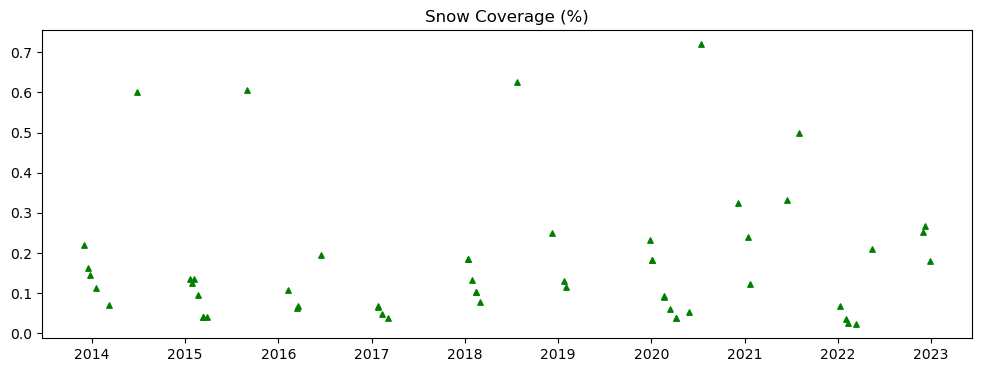

In [18]:
plt.figure(figsize = (12,4))
plt.title('Snow Coverage (%)')
plt.scatter(df_Villarrica['date'], df_Villarrica['Snow %'], s=15 , marker='^', c='g')

Below we will show the images to see the snow melting during the 2013-2014 summer (first 5 images)

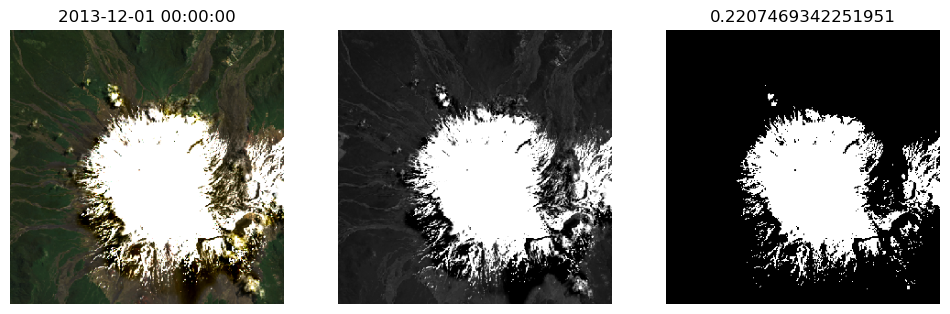

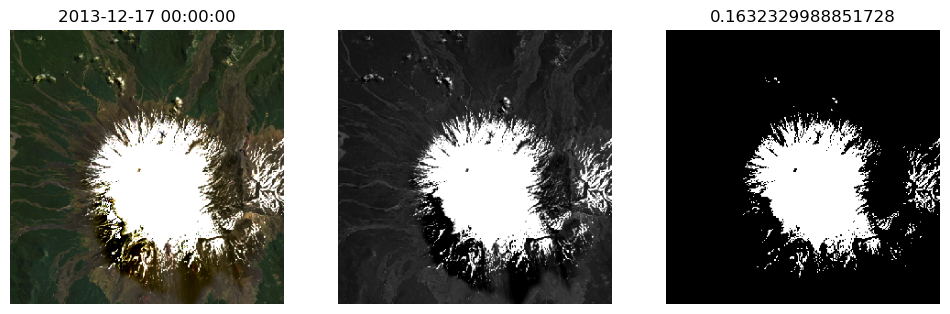

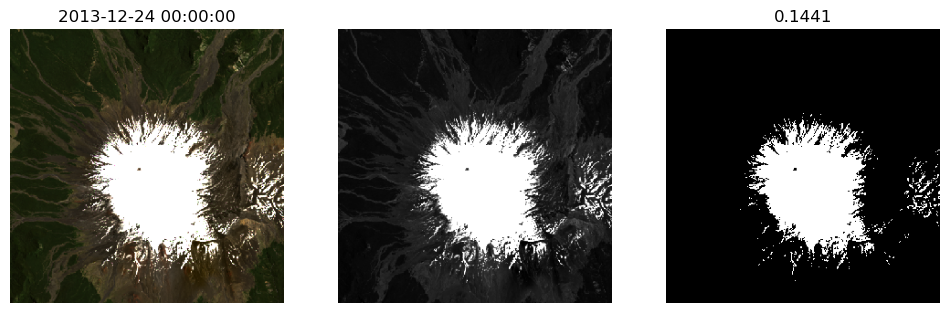

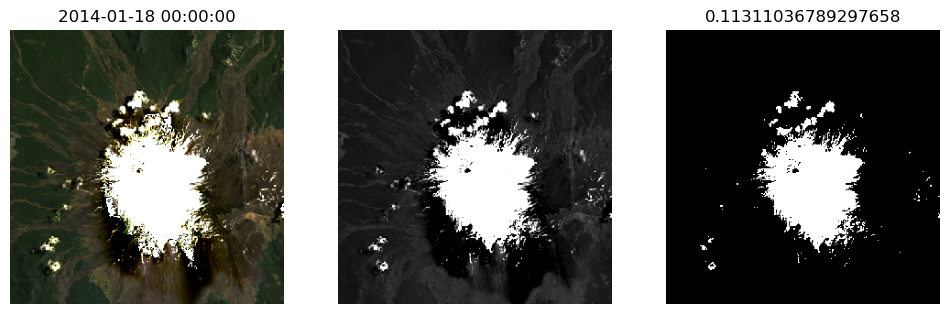

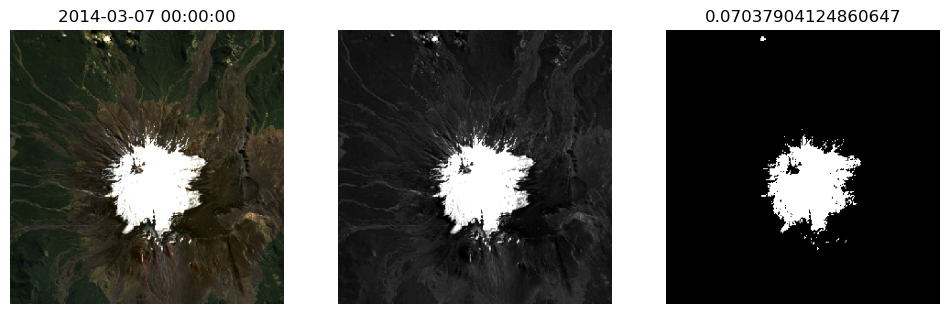

In [19]:
for i in range(0,5):

    f, axarr = plt.subplots(1,3, figsize = (12,5))

    # Imagen 1
    #axarr[0].figure(figuresize = (3,3))
    axarr[0].imshow(df_Villarrica.iloc[i]['RGB Img'])
    axarr[0].axis('off')
    axarr[0].title.set_text(df_Villarrica.iloc[i]['date'])

    #Imagen 2
    axarr[1].imshow(df_Villarrica.iloc[i]['Single Band Img'], cmap='gray')
    axarr[1].axis('off')

    #Imagen 3
    axarr[2].imshow(df_Villarrica.iloc[i]['Binary Img'], cmap='gray')
    axarr[2].axis('off')
    axarr[2].title.set_text((df_Villarrica.iloc[i]['Snow %']))

    np.set_printoptions(suppress=True)